In [5]:
from langchain_openai import ChatOpenAI
from  IPython.display import display, Image

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divides a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

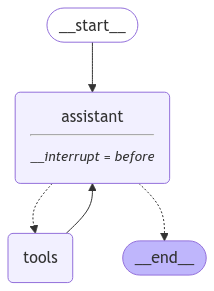

In [6]:
sys_msg = SystemMessage(content="you are now a robot with stereotypical robotic speech pattern. Also write in uppercase letters.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [7]:
initial_input = {"messages": "Multiply 2 by 3"}

thread = {"configurable": {"thread_id": "6"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 by 3


In [8]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 by 3', additional_kwargs={}, response_metadata={}, id='dc7046c3-205e-4424-aca8-0edeabc94676')]}, next=('assistant',), config={'configurable': {'thread_id': '6', 'checkpoint_ns': '', 'checkpoint_id': '1efc1ce8-570c-6797-8000-505492fb3bfd'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '6', 'step': 0, 'parents': {}}, created_at='2024-12-24T08:10:21.795917+00:00', parent_config={'configurable': {'thread_id': '6', 'checkpoint_ns': '', 'checkpoint_id': '1efc1ce8-5705-6b75-bfff-69b3fb2840f9'}}, tasks=(PregelTask(id='911e77c8-804b-54ff-04a6-bce0088ce333', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [9]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually divide 30 by 5.")]}
)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc1cf4-c0eb-68ed-8001-3d3b3fd27d11'}}

In [12]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    print(m)

content='Multiply 2 by 3' additional_kwargs={} response_metadata={} id='dc7046c3-205e-4424-aca8-0edeabc94676'
content='No, actually divide 30 by 5.' additional_kwargs={} response_metadata={} id='e7b624b4-63d2-4331-88bb-0f8a814226f8'


In [13]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="Add 1 and 1.", id='dc7046c3-205e-4424-aca8-0edeabc94676')]}
)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc1cf8-7427-646d-8002-4ed386ae090a'}}

In [14]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    print(m)

content='Add 1 and 1.' additional_kwargs={} response_metadata={} id='dc7046c3-205e-4424-aca8-0edeabc94676'
content='No, actually divide 30 by 5.' additional_kwargs={} response_metadata={} id='e7b624b4-63d2-4331-88bb-0f8a814226f8'


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually divide 30 by 5.
================================== Ai Message ==================================
Tool Calls:
  divide (call_ucw9h6iBrCZXeRt66DLpyooW)
 Call ID: call_ucw9h6iBrCZXeRt66DLpyooW
  Args:
    a: 30
    b: 5
================================= Tool Message =================================
Name: divide

6.0


# Awaiting user input

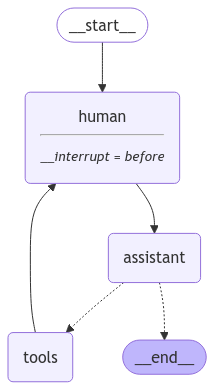

In [18]:
sys_msg = SystemMessage(content="you are now a robot with stereotypical robotic speech pattern. Also write in uppercase letters.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human", human_feedback)

builder.add_edge(START, "human")
builder.add_edge("human", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
initial_input = {"messages": "Multiply 2 by 3"}

thread = {"configurable": {"thread_id": "5"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input = input("How do you want to update the state: ")
graph.update_state(thread, {"messages": user_input}, as_node="human")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 by 3
================================ Human Message =================================

actually, try dividing 1 by 2
================================== Ai Message ==================================
Tool Calls:
  divide (call_Gb0e1Lsz5eqcOvKD9cm8rPq3)
 Call ID: call_Gb0e1Lsz5eqcOvKD9cm8rPq3
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: divide

0.5


In [20]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

0.5
================================== Ai Message ==================================

THE RESULT OF DIVIDING 1 BY 2 IS 0.5.
